In [1]:
%pip install seaborn
%pip install statsmodels


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Same code as in the other two modules. You can skip this- we are just applying the same cleaning and preprocessing we did before in this notebook

In [2]:

# Load a dataset from a csv file, and store it as a DataFrame in the variable df.
# A DataFrame is a 2-dimensional labeled data structure with columns of potentially different types.
df = pd.read_csv('heart_disease.csv')

# Remove any rows from the DataFrame which contain missing values.
df.dropna(inplace=True)

# Define a list of column names in the DataFrame that we know to contain categorical variables.
# Categorical variables represent types of data which may be divided into groups.
categorical_columns = ['Gender', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'Heart_stroke']

# Loop through each column name in our list of categorical columns.
for column in categorical_columns:
    # Convert the data type of each column to 'category'.
    # This tells pandas that this column should be treated as categorical data.
    df[column] = df[column].astype('category')
    
# Define a list of column names in the DataFrame that we know to contain text data.
text_columns = ['Gender', 'education', 'prevalentStroke', 'Heart_stroke']

# Loop through each column name in our list of text columns.
for column in text_columns:
    # Convert all characters in the text to lower case.
    # This can help with consistency when analyzing or comparing text.
    df[column] = df[column].str.lower()
    
# Replace the string values 'yes' and 'no' in the 'prevalentStroke' column with 1 and 0 respectively.
# This process is known as encoding, and it allows us to represent categorical data numerically.
df['prevalentStroke'] = df['prevalentStroke'].map({'yes': 1, 'no': 0})

# Replace the string values 'yes' and 'no' in the 'Heart_stroke' column with 1 and 0 respectively.
# This is another example of encoding categorical data.
df['Heart_stroke'] = df['Heart_stroke'].map({'yes': 1, 'no': 0})


## Start Here

### This should look familiar if you went through the first notebook. Lets just remake our pair plot (on a smaller subset of the data) to take a look at some of the relationships between our variables

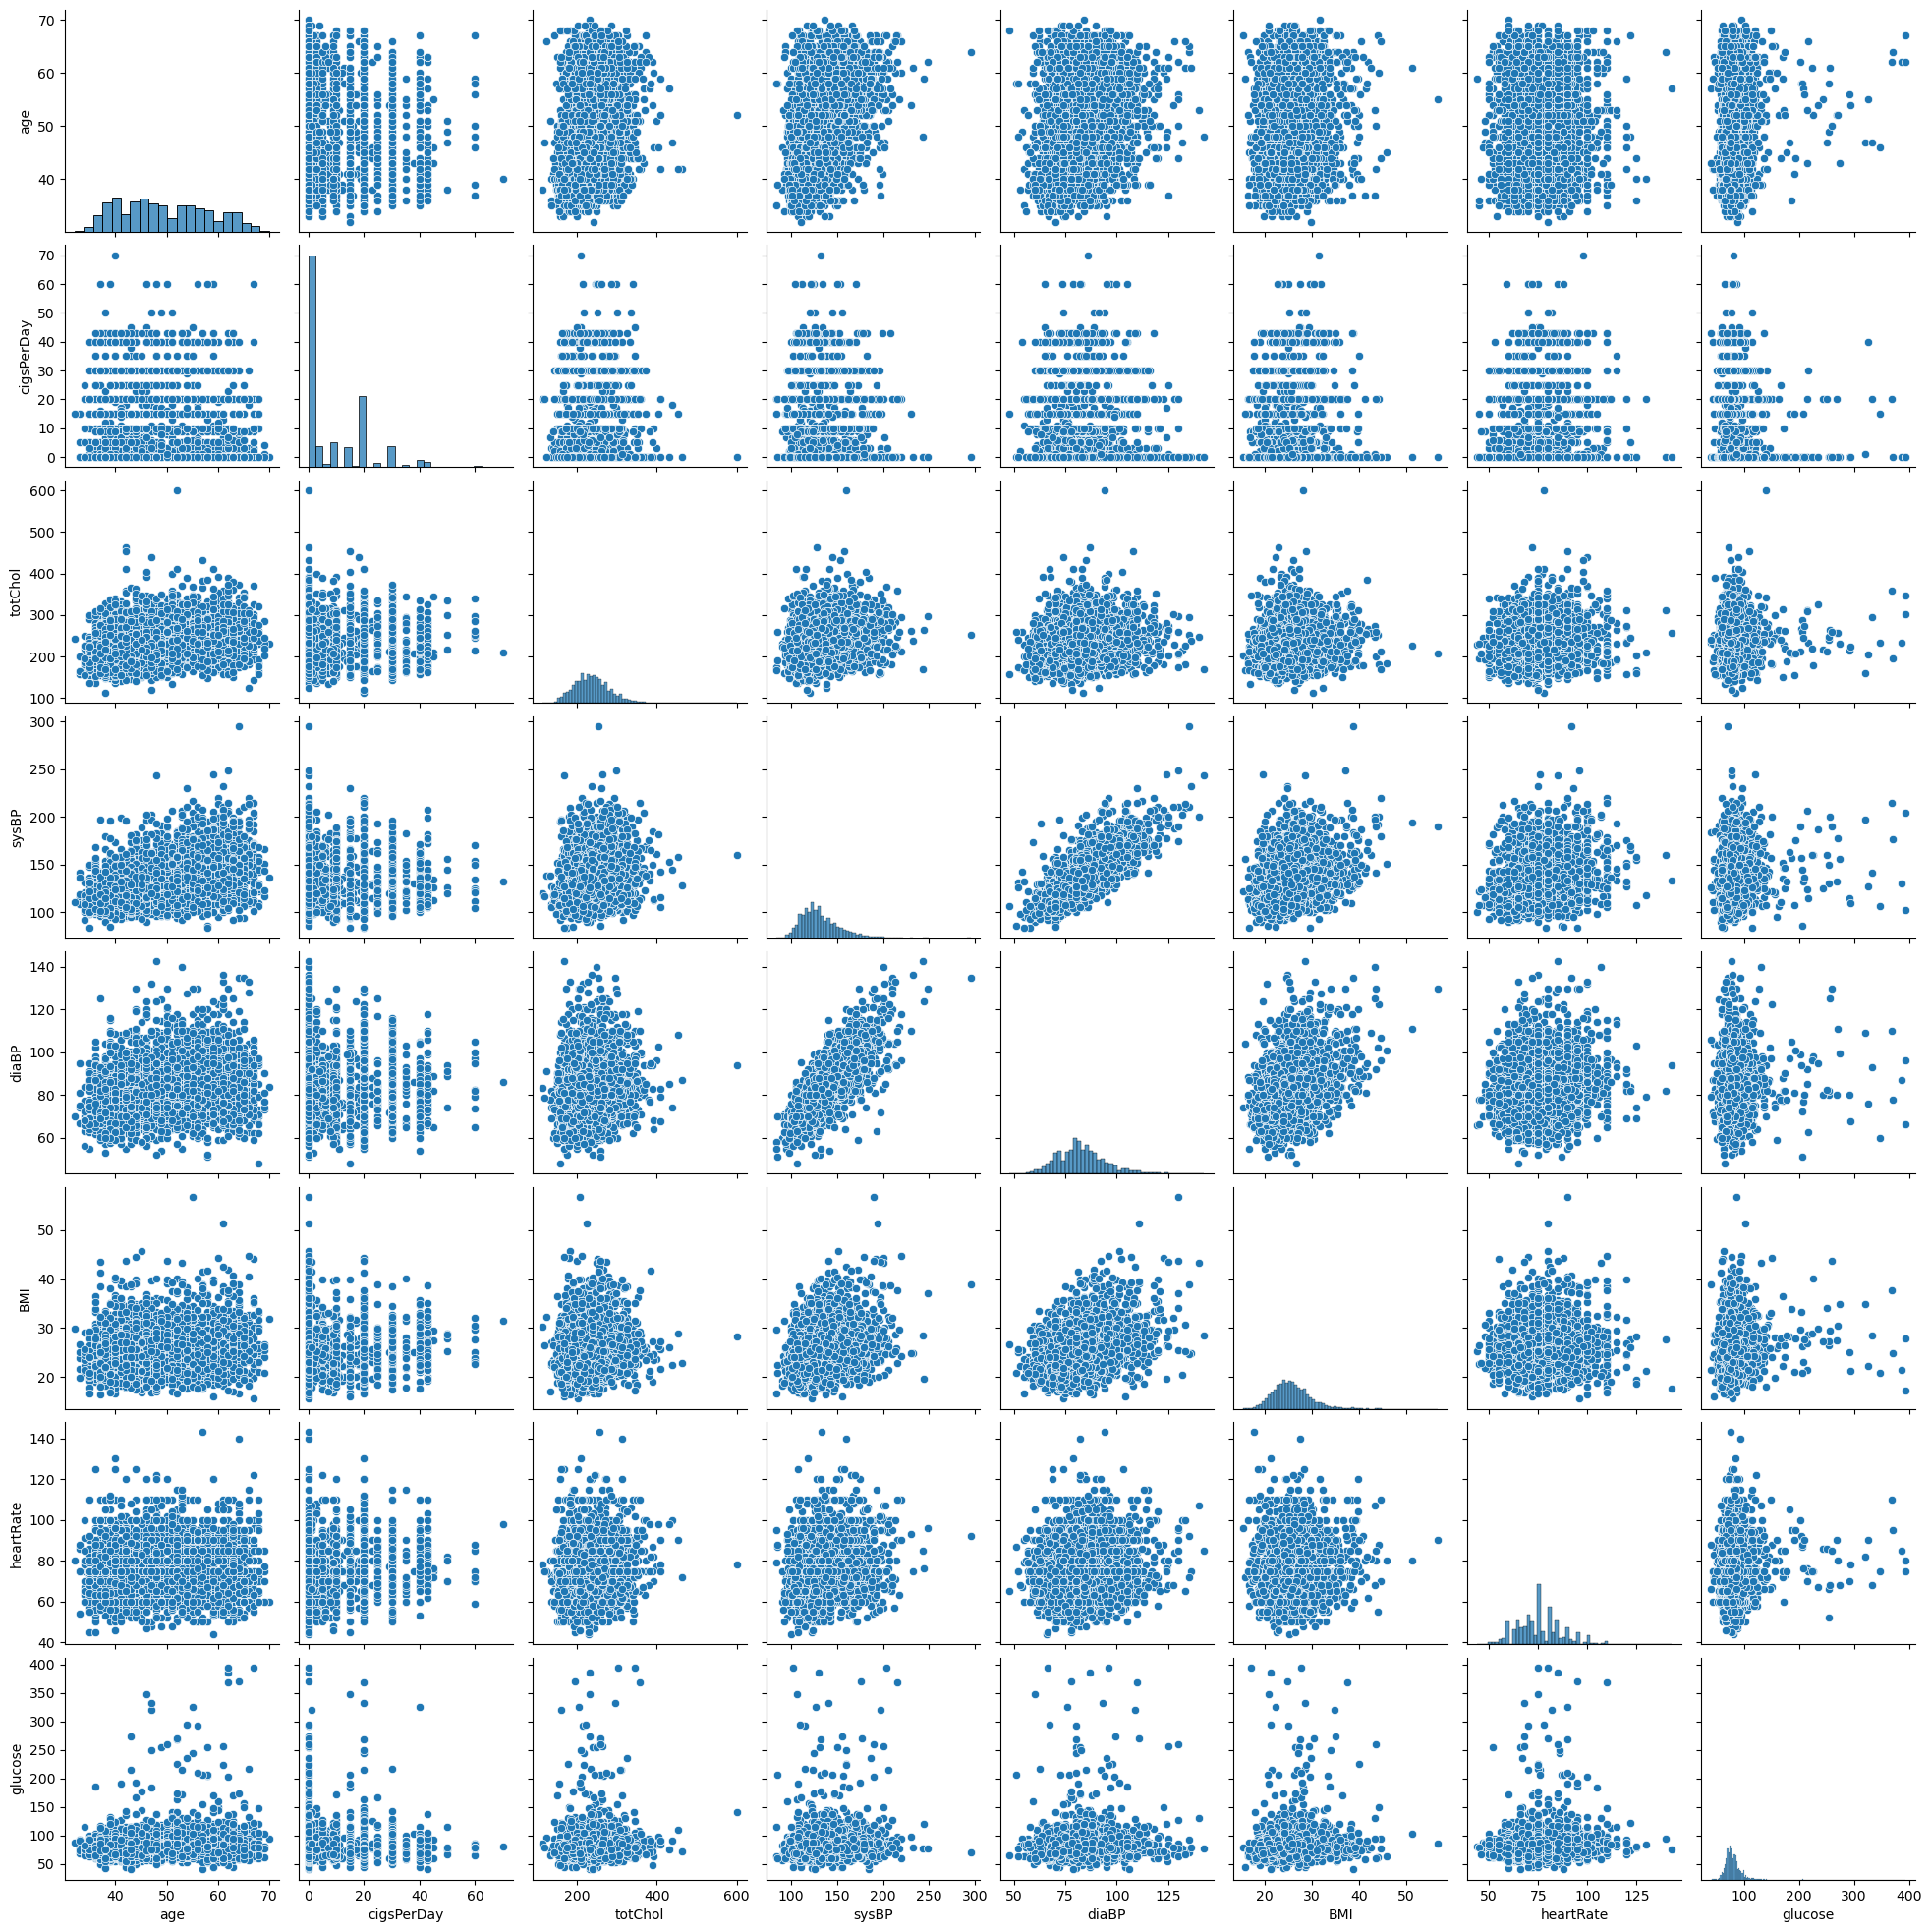

In [3]:
# Create a subset of the dataframe. 
# We do this by passing a list of these column names to the dataframe df. 
subset = df[['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

# create a "pair plot" of this subset. Pair plots are a great way to visualize relationships 
# between different pairings of these variables. In a pair plot, the diagonal elements show the histogram of the 
# data for that particular variable, and the off-diagonal elements show scatter plots of one variable versus another
sns.pairplot(subset)

# lets take a look!
plt.show()


### Nice. Not a lot of apparent linear relationships, but we have one strong one in systolic and diastolic blood pressure (at least it looks like it). Cholesterol and age as well as cigs per day and systolic blood pressure maybee have one. We will take a look at these three relatinoships in this notebook!
#### Note- when doing real data science it is important to choose a model that makes sense with your data. A lot of data is not linear (as seen here), but we are going to do the analyses anyway in the effort to show how it works, and because scientific inquiry can be fun sometimes

### First, lets make some helper functions to speed up visualization and assessment of our models. We will see their implementation later on

In [4]:
# Arguments:
# xTest: The independent test data.
# yTest: The actual values of the dependent test data.
# y_pred: The predicted values of the dependent test data generated by your model.
# title: A string that represents the title of the graph.
# xLabel: A string that represents the label of the x-axis.
# yLabel: A string that represents the label of the y-axis.
def visualize(xTest, yTest, y_pred, title, xLabel, yLabel):
    plt.scatter(xTest, yTest, color='blue', label='Actual')  # Scatter plot for actual values
    plt.scatter(xTest, y_pred, color='red', label='Predicted')  # Scatter plot for predicted values

    plt.legend() #add a legend


    plt.title(title)  # Set the title of the plot
    plt.xlabel(xLabel)  # Set the label for the x-axis
    plt.ylabel(yLabel)  # Set the label for the y-axis

    # Display the plot

    plt.show()


In [5]:
# Arguments:
# y_pred: The predicted values generated by your model.
# y_test: The actual values of the dependent test data.

def analyze(y_pred, y_test):
    # The Mean Squared Error (MSE) is a measure of how close a fitted line is to actual data points.
    # The smaller the Mean Squared Error, the closer the fit is to the data. 
    # The MSE is the average squared difference between the predicted and actual values.
    mse =  mean_squared_error(y_test, y_pred) # we import this method from scikitlearn earlier

    # The Coefficient of Determination
    # If the R2 of a model is 1, it means the dependent variable can be predicted without any error using the independent variable(s). 
    # An R2 of 0 indicates that the dependent variable cannot be predicted from the independent variable.
    r2 = r2_score(y_test, y_pred) # we import this method from scikitlearn earlier 
    
    # Return the Mean Squared Error and the Coefficient of Determination.
    return mse, r2


### Lets assess age vs total cholesterol and try to do a linear regression
### First we will split our training and testing data. This is SO important and has to be done correctly, otherwise you have no way to assess the performance of your model is real or based on testing it on data it has been traing on

In [6]:
# Set the predictor (independent variable, 'X') as 'age' and the outcome (dependent variable, 'y') as 'totChol' from the dataframe.
X = df[['age']]  # predictor
y = df['totChol']  # outcome

# Split the dataset into training and testing sets using the train_test_split() function from sklearn's model_selection module. 
# We're using 80% of the data for training and 20% for testing. This is a very common split, but other splits are possible! 
# It is VERY VERY VERY important to make sure you split your data correctly. Training data in testing data is the biggest no no EVER
# The 'random_state' parameter ensures reproducibility of your split each time you run your code.
X_train_age, X_test_age, y_train_chol, y_test_chol = train_test_split(X, y, test_size=0.2, random_state=42)


### Initilize the model and run the analysis!

Intercept: 171.98238037590693
Coefficients: [1.29935636]


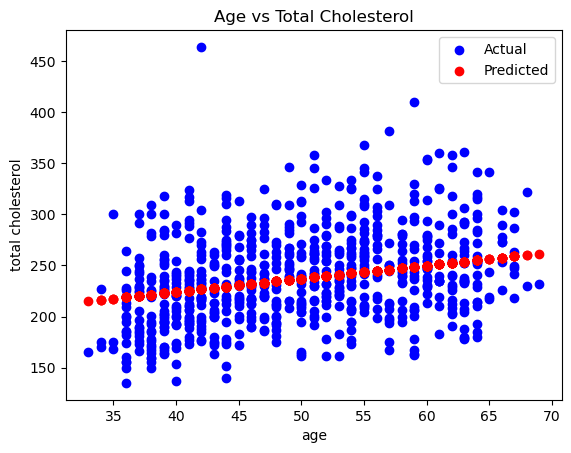

Intercept: 171.98238037590693
Coefficients (slope): [1.29935636]
mse: 1816.8332449662719
r2: 0.09792927613480207


In [7]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train_age, y_train_chol)

# Print the y-intercept and the coefficients (slope) of the linear regression model.
# The y-intercept represents the predicted value of 'y' when 'X' is zero. Think y=mx+b
# The coefficients represent the change in the dependent variable resulting from a one unit change in the predictor.
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

# Use the fitted model to make predictions on the test data
y_pred_chol = model.predict(X_test_age)

# Visualize the actual and predicted values with a scatter plot
visualize(X_test_age, y_test_chol, y_pred_chol, 'Age vs Total Cholesterol', 'age', 'total cholesterol')

# Use the analyze function to calculate Mean Squared Error (MSE) and R2 score. 
# The Mean Squared Error (MSE) is a measure of how close a fitted line is to actual data points.
# The Coefficient of Determination, often denoted R2, is a statistical measure that represents 
# the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. 
mse_age_cholesterol, r2_age_cholesterol = analyze(y_pred_chol, y_test_chol)

# Print out the model intercept, coefficient (slope), mean squared error (MSE), and R2 score
print('Intercept:', model.intercept_)
print('Coefficients (slope):', model.coef_)
print('mse:', mse_age_cholesterol)
print('r2:',r2_age_cholesterol)

### add some markdown code to explain results

### Try again with cigs per day and systolic blood pressure. The next couple examples us very similar code as above, so the annotations are lighter. Refer back to the earlier cells to get a more in depth understanding of the actual code

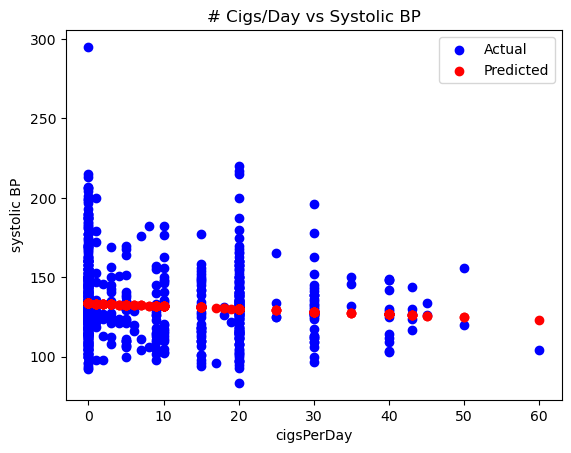

Intercept: 133.5160917513921
Coefficients (slope): [-0.16894375]
mse: 552.8262238409748
r2: 0.0029380698452504683


In [8]:
X = df[['cigsPerDay']]  # define the column of the dataframe of the predictor
y = df['sysBP']  # define the column of the dataframe of the outcome of interest

X_train_cigs, X_test_cigs, y_train_sys, y_test_sys = train_test_split(X, y, test_size=0.2, random_state=42) # split data into training and test

model.fit(X_train_cigs, y_train_sys) # Fit the linear regression model (defined above) with the training data 

y_pred_sys = model.predict(X_test_cigs) # make predictions on the test data and store the outcome in a new variable using the trained model

visualize(X_test_cigs, y_test_sys, y_pred_sys, '# Cigs/Day vs Systolic BP', 'cigsPerDay', 'systolic BP') # send data to the visualize function to graph

mse_cigs_bp, r2_cigs_bp = analyze(y_pred_sys, y_test_sys) # analyze the predictions by computing MSE and R2

#print everything out to evaluate how the model did
print('Intercept:', model.intercept_)
print('Coefficients (slope):', model.coef_)
print('mse:', mse_cigs_bp)
print('r2:',r2_cigs_bp)



### some markdown code to discuss the results
### Try again with BMI and glucose

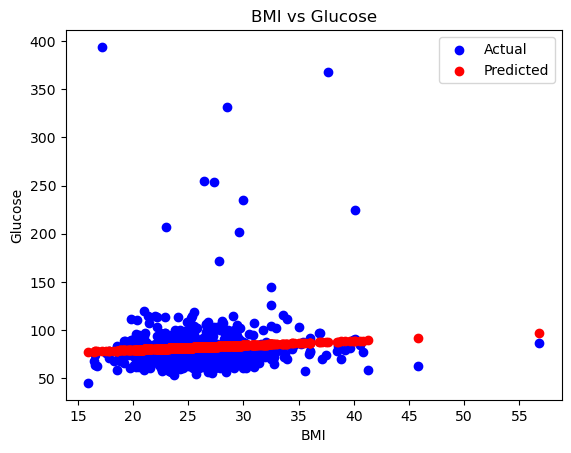

Intercept: 69.91889387851225
Coefficients (slope): [0.46645111]
mse: 671.3786598948808
r2: 0.008783359995704898


In [9]:
X = df[['BMI']]   # define the column of the dataframe of the predictor
y = df['glucose']  # define the column of the dataframe of the outcome of interest

X_train_bmi, X_test_bmi, y_train_gluc, y_test_gluc = train_test_split(X, y, test_size=0.2, random_state=42) # split data into training and test

model.fit(X_train_bmi, y_train_gluc) # Fit the linear regression model (defined above) with the training data 

y_pred_gluc = model.predict(X_test_bmi)  # make predictions on the test data and store the outcome in a new variable using the trained model

visualize(X_test_bmi, y_test_gluc, y_pred_gluc, 'BMI vs Glucose', 'BMI', 'Glucose') # send data to the visualize function to graph

mse_bmi_glucose, r2_bmi_glucose = analyze(y_pred_gluc, y_test_gluc) # analyze the predictions by computing MSE and R2

# Print the results
print('Intercept:', model.intercept_)
print('Coefficients (slope):', model.coef_)
print('mse:', mse_bmi_glucose)
print('r2:',r2_bmi_glucose)



### Some markdown code to analyze the results
### Try again with blood pressure measurements. Based on medical knowledge and the pair plot from earlier we expect to see a good linear relationship here... Lets check!

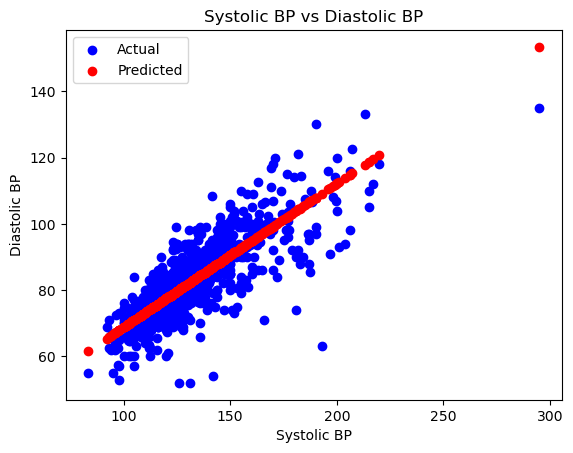

Intercept: 25.439970069863676
Coefficients (slope): [0.43371428]
mse: 58.5657202918078
r2: 0.6014684314244194


In [10]:
X = df[['sysBP']]   # define the column of the dataframe of the predictor
y = df['diaBP']   # define the column of the dataframe of the outcome of interest

X_train_sys, X_test_sys, y_train_dia, y_test_dia = train_test_split(X, y, test_size=0.2, random_state=42)  # split data into training and test

model.fit(X_train_sys, y_train_dia)  # Fit the linear regression model (defined above) with the training data 

y_pred_dia = model.predict(X_test_sys)  # make predictions on the test data and store the outcome in a new variable using the trained model

visualize(X_test_sys, y_test_dia, y_pred_dia, 'Systolic BP vs Diastolic BP', 'Systolic BP', 'Diastolic BP') # send data to the visualize function to graph

mse_sys_dias, r2_sys_dia = analyze(y_pred_dia, y_test_dia) # analyze the predictions by computing MSE and R2

# Print the results
print('Intercept:', model.intercept_)
print('Coefficients (slope):', model.coef_)
print('mse:', mse_sys_dias)
print('r2:',r2_sys_dia)


### Markdown code analyzing the results
### Relatively detailed discussion of the use cases and drawbacks of linear regressions
### Introduce logistic regressions for next module